# Module 4: Practice

This week's exercises examines different methods of collecting Twitter data in realtime. Before we start doing any specific tasks, load rtweet and the tidyverse.

In [1]:
library(rtweet)
suppressPackageStartupMessages(library(tidyverse))

### 1. Use the `statuses/sample` API to stream a "random sample" of tweets for 5 minutes.

In [2]:
st1 <- stream_tweets(timeout = 60 * 5)

Streaming tweets for 300 seconds...


Downloading: 5.3 MB       

Finished streaming tweets!
opening file input connection.


 Imported 3577 records. Simplifying...


closing file input connection.


### 2. Try to exploit the `statuses/filter/track` API to get as many tweets as indiscriminately as you can for 5 minutes. Here's I've given you two different hacks I quickly came up with for doing this:

In [9]:
## i went to : https://www.google.com/search?q=language+translation 
## and translated the word "the" into the following languages:
## arabic, chinese, finnish, french, german, hindi, indonesian, japanese, mongolian, portugese, russian, spanish
qthe <- "و,和,ja,the,et,und,तथा,dan,そして,e,과,болон,e,а также,ve,y"

## i wanted to find a way to search for spaces. the plus sign operates like a space, so i figured I'd try
## something weird like this
qpunct <- "+-,+.,+ "

## enter qthe or qpunct in the first argument below
st2 <- stream_tweets(qpunct, timeout = 60 * 5)

Streaming tweets for 300 seconds...


Downloading: 3.5 MB       

Finished streaming tweets!
opening file input connection.


 Imported 2214 records. Simplifying...


closing file input connection.


### 3. Use the `statuses/filter/locations` API to stream tweets from all over the world for 5 minutes.

In [4]:
st3 <- stream_tweets(lookup_coords("world"), timeout = 60 * 5)

Streaming tweets for 300 seconds...


Downloading: 4.3 MB       

Finished streaming tweets!
opening file input connection.


 Imported 3225 records. Simplifying...


closing file input connection.


### 4. Merge the tweets data with the users data for each of the 3 data sets gathered in 1-3.

In [5]:
## function to join
join_rtweet <- function(x) {
    users <- users_data(x)
    users <- users[, names(users) != "screen_name"]
    users <- users[!duplicated(users$user_id), ]
    dplyr::left_join(x, users, by = "user_id")
}

## merge tweets and users data for each
st1 <- join_rtweet(st1)
st2 <- join_rtweet(st2)
st3 <- join_rtweet(st3)

### 5. (a) Create a new variable named `stream_method` for each of the data sets. Using the strings `"statuses/sample"`, `"statuses/filter/track"`, and `"statuses/filter/locations"`, assign the values for the new variable in each data set appropriately. (b) Merge all three data sets into a single data set.

In [6]:
## create stream_method variable
st1$stream_method <- "statuses/sample"
st2$stream_method <- "statuses/filter/track"
st3$stream_method <- "statuses/filter/locations"

## bind by row all three data sets
st <- rbind(st1, st2, st3)

### 6. Extract the following features as numeric variables (use names in parentheses when provided):
+ account_created_at 
+ is_retweet 
+ is_quote
+ is_reply (reply_to_status_id)
+ is_verified (verified)
+ tweet_chars (text)
+ bio_chars (description)
+ hashtags (hashtags),
+ mentions (mentions_user_id)
+ medias (ext_media_url)
+ lang_en (lang)
+ lang_pt (lang)
+ lang_es (lang)
+ lang_ja (lang)
+ lang_other (lang)

Hint: use the function `count_elems()` defined below to count the number of hashtags, mentions, and media attachments.

In [7]:
## create function to count number of hashtags, media attachments, and mentions
count_elems <- function(x) {
    sapply(x, function(x) {
        ifelse(length(x) == 0L || (length(x) == 1L && is.na(x)), 
               0L, length(x))
    })
}

## hint: Twitter uses language ISO codes and these are a few of the popular languages. for our purposes,
## including english/not-english, would work to illustrate whether we are disproportionately sampling 
## from english tweets

## extract and convert features to numeric
st_features <- st %>%
    mutate(
        account_created_at = as.numeric(account_created_at),
        ## I converted the account creation date to years from the oldest account's origin date
        account_created_at = (max(account_created_at) - account_created_at) / (60 * 60 * 24 * 365),
        is_retweet = as.integer(is_retweet),
        is_quote = as.integer(is_quote),
        is_reply = as.integer(!is.na(reply_to_status_id)),
        is_verified = as.integer(verified),
        tweet_chars = stringi::stri_width(text),
        bio_chars = ifelse(is.na(description), 0L, stringi::stri_width(description)),
        hashtags = count_elems(hashtags),
        mentions = count_elems(mentions_user_id),
        medias = count_elems(ext_media_url),
        lang_en = as.integer(lang == "en"),
        lang_pt = as.integer(lang == "pt"),
        lang_es = as.integer(lang == "es"),
        lang_ja = as.integer(lang == "ja"),
        lang_other = as.integer(!lang %in% c("en", "pt", "es", "ja"))) %>%
    mutate_if(is.integer, as.numeric) %>%
    select(stream_method, account_created_at, is_retweet, is_quote, is_reply,
           is_verified, tweet_chars, bio_chars, hashtags, mentions, medias, lang_en:lang_other)

### 7. Group by stream_method, summarise, and plot displaying the mean of each streaming method for each numeric variable.

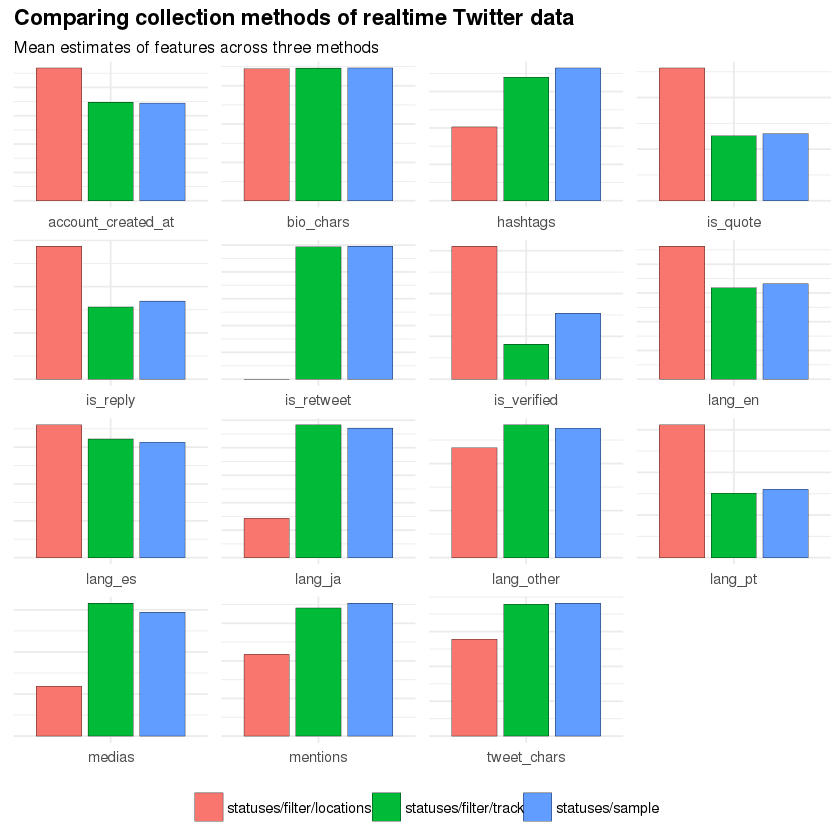

In [8]:
## group, summarise, and then plot
st_features %>%
    group_by(stream_method) %>%
    summarise_if(is.numeric, mean) %>%
    gather(var, mean, -stream_method) %>%
    ggplot(aes(x = var, y = mean, fill = stream_method)) + 
    geom_col(size = .1, colour = "black", width = .7, 
             position = position_dodge(width = .8)) + 
    theme_minimal() + 
    facet_wrap( ~ var, scales = "free", ncol = 4) + 
    theme(plot.title = element_text(face = "bold"),
          legend.position = "bottom", 
          axis.text.y = element_blank(),
          legend.title = element_blank(),
          strip.text = element_blank()) + 
    labs(title = "Comparing collection methods of realtime Twitter data",
        subtitle = "Mean estimates of features across three methods",
        x = NULL, y = NULL)

### 8. Based on the graphic you created in the previous step, which method would be best if the goal was to get a representative snapshot on Twitter? There is no wrong answer here. Briefly describe strengths and weaknesses of each and then make a judgment call.

> type your answer below - it should probably take you around 6-10 sentences


All three methods have strengths and weaknesses, so there's no clear-cut answer. What is the best way to describe a "representative" snapshot of Twitter? My first instinct is to look for tweets that contribute towards a "conversation"--tweets that are original, use hashtags, and come from a respected (verified) source. With that in mind, the "locations" filter pulled the most verified tweets and also has basically no retweets, so high marks for original content. The random sampling pulled the most hashtags, came from a well-balanced mix of languages, and had a low number of quoted tweets. The tracking method had a good mix of quoted/reply tweets as well, but a low number of verified tweets. 

Okay, the more I look at the data the more I think the random sampling was the best. I was initially thinking I would penalize a method for having too many retweets, but that's a very large part of how tweets are shared on twitter. It's a low-effort, high-impact "co-sign" to a message. Combined with high marks for hashtag use and medium verification count, I think it was the best result for a twitter snapshot.